# The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Setup & imports

In [19]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
%matplotlib inline

from utils import helper
from utils import camera
from utils import threshold


# 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

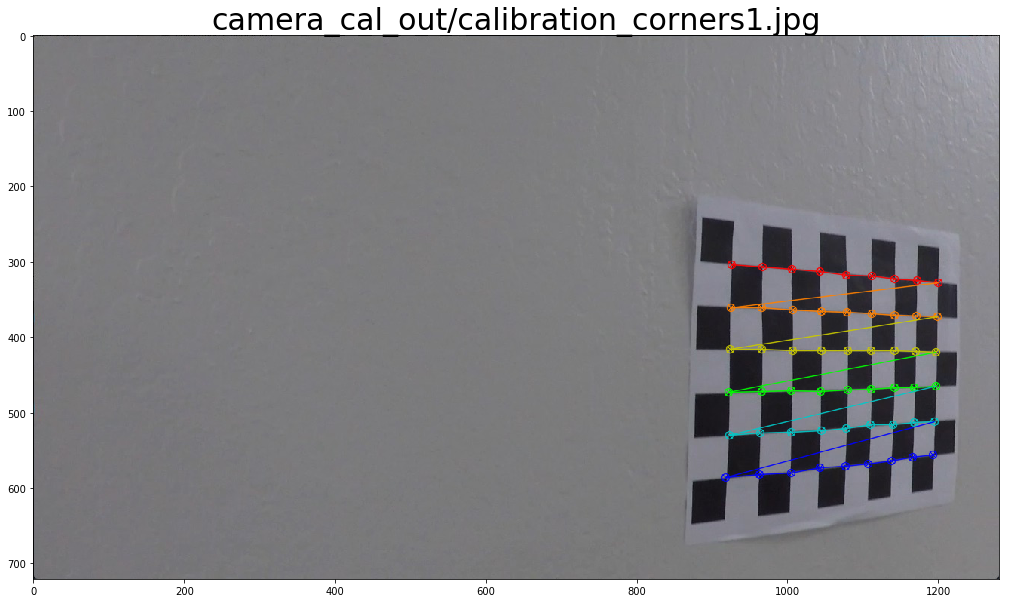

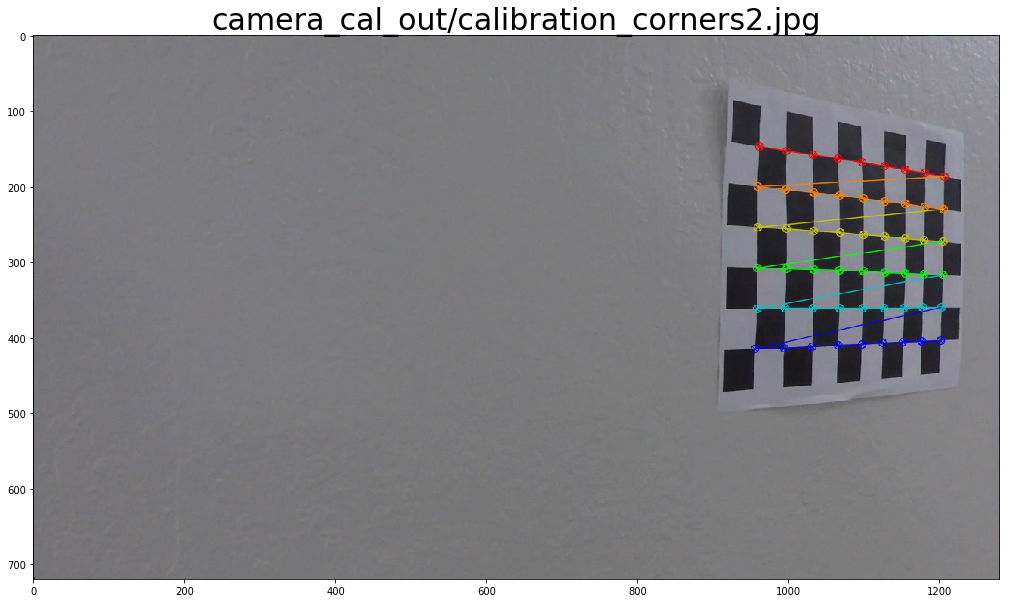

completed calibration & undistortion


In [36]:
#save calibration outputs for chess corners & undistort in output directory
outDirectory = 'camera_cal_out'
if not os.path.exists(outDirectory):
    os.makedirs(outDirectory)
    
#call method for the 20 calibration images in folder
calibrate_img_paths = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = camera.calibrate_camera(calibrate_img_paths, 9, 6, outDirectory)

# Save the camera calibration result for later use & save time (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "{}/mtx_dist_pickle.p".format(outDirectory), "wb" ) )

print('completed calibration & undistortion')

# 2. Apply a distortion correction to raw images

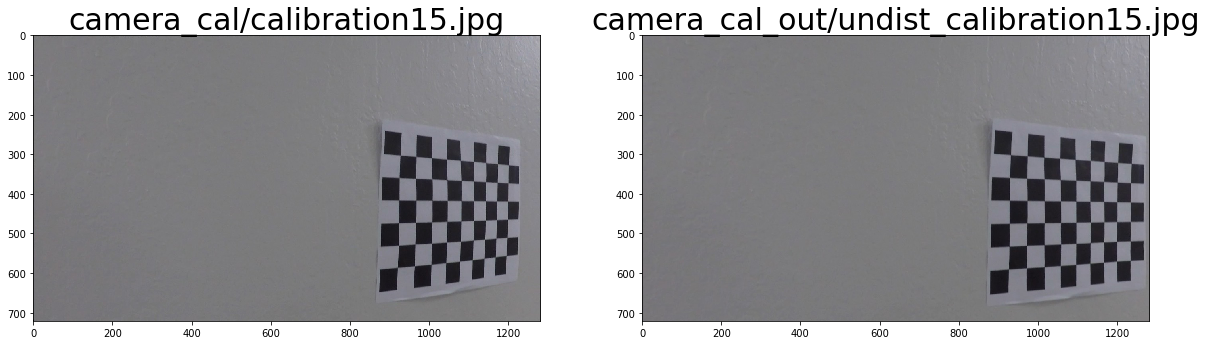

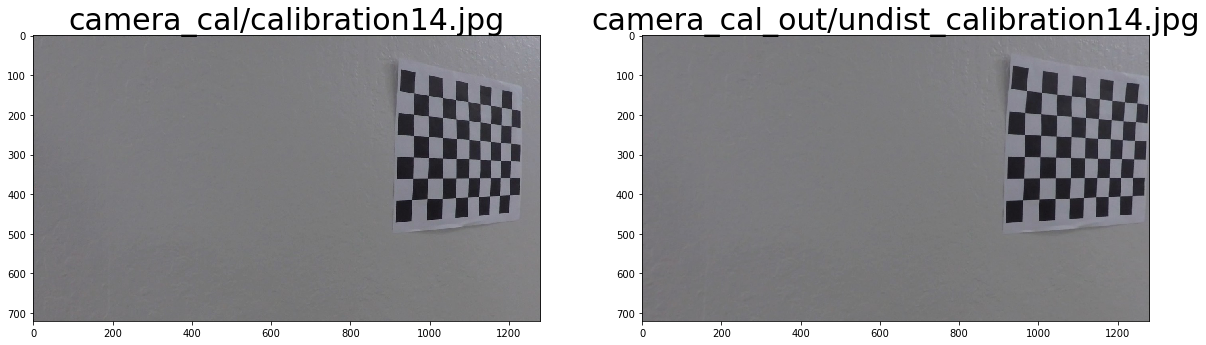

undistortion completed


In [37]:
def undistort_bulk(paths, outDir=None):
    #load pickled mtx, dist & run undistort
    # load the object from the file into var b
    pickle_load = pickle.load(open("{}/mtx_dist_pickle.p".format(outDirectory),'rb'))  
    # print(pickle_load)
    camera.undistort(pickle_load['mtx'], pickle_load['dist'], paths, outDir)
    print('undistortion completed')
    
undistort_bulk(calibrate_img_paths, outDirectory)


## 2.a Undistorting test images and saving them in output images

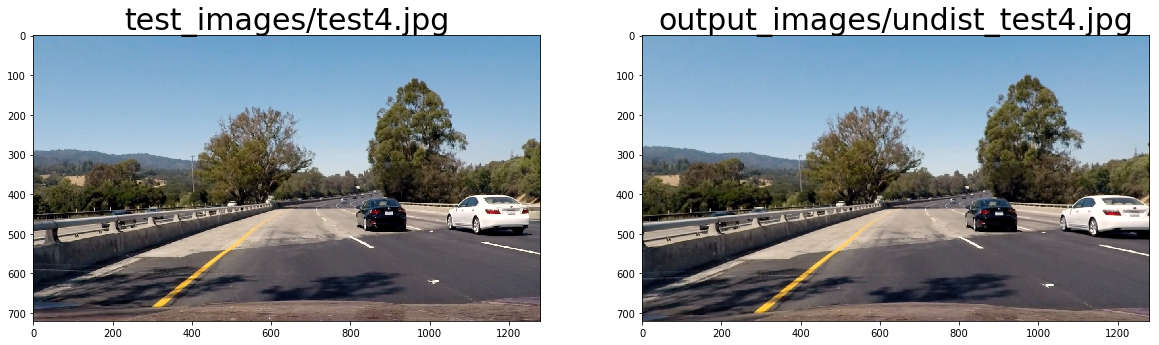

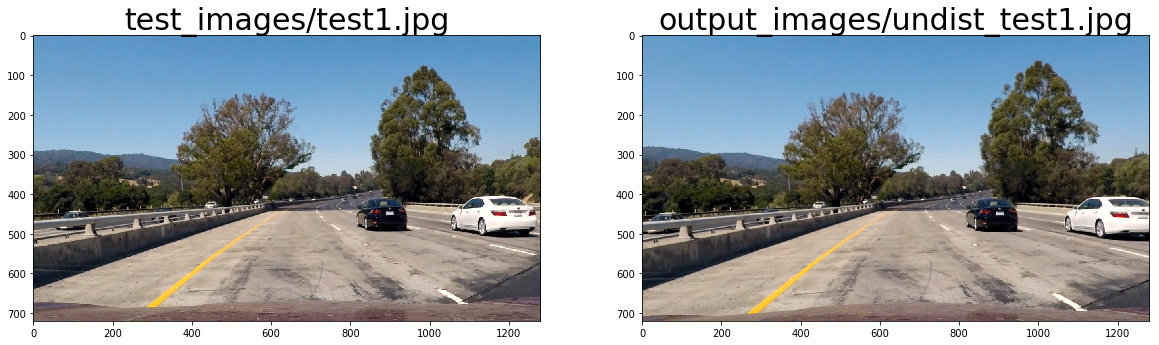

undistortion completed


In [13]:
test_image_paths = glob.glob('test_images/*.jpg')

undistort_bulk(test_image_paths, 'output_images')

# 3. Use color transforms, gradients, etc., to create a thresholded binary image.

Lets define different transforms that we can apply on undistorted images produced above to get thresholded binary images. Remember to use mpimg.imread outputs in RGB while cv2.imread in BGR (great for confusing). Here after experimenting with HLS channels and sobel gradients, combination of sobelx & L/S channels leads to good results.

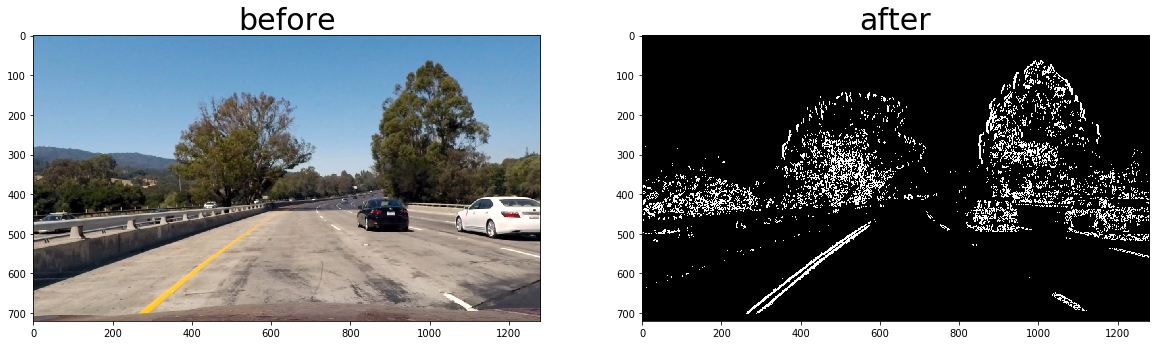

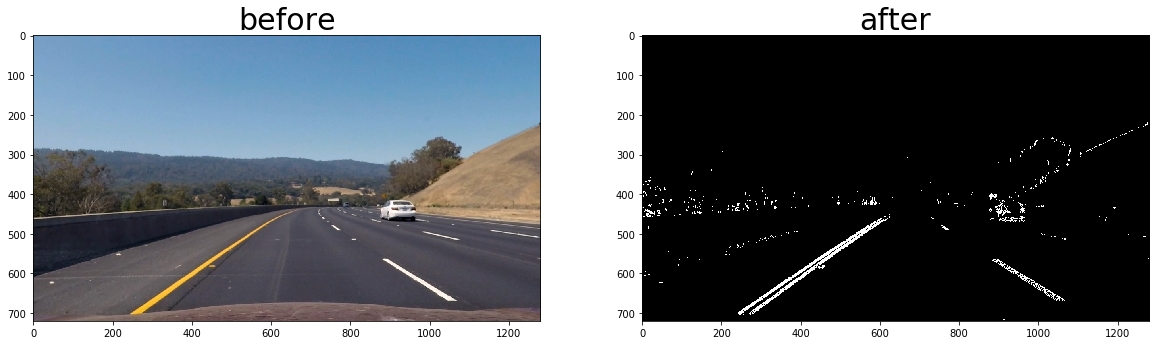

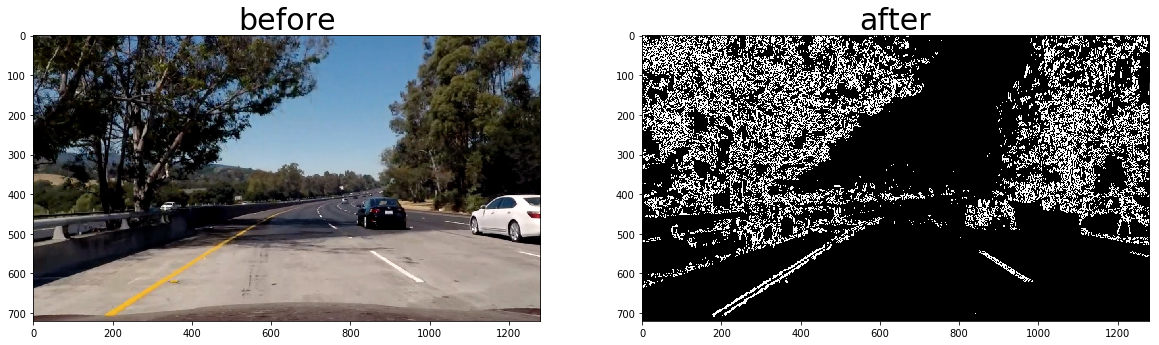

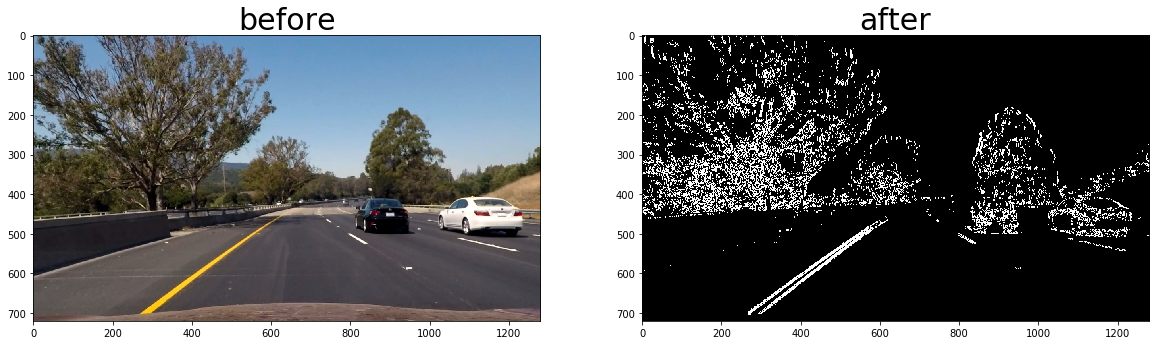

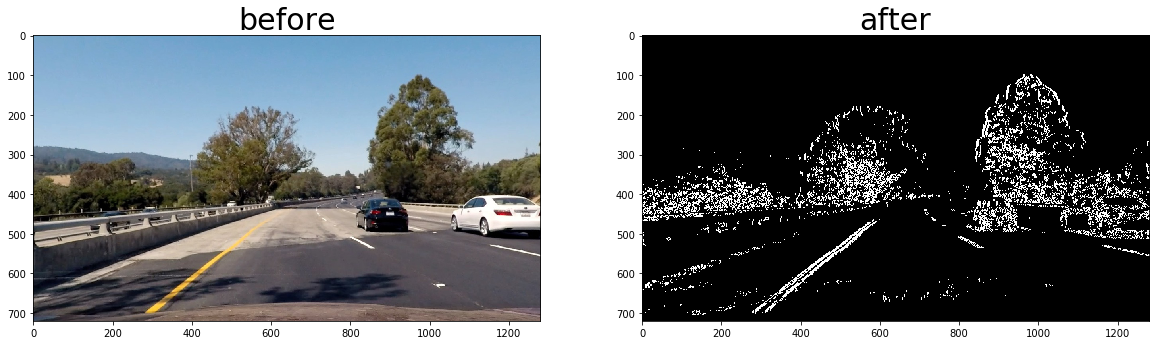

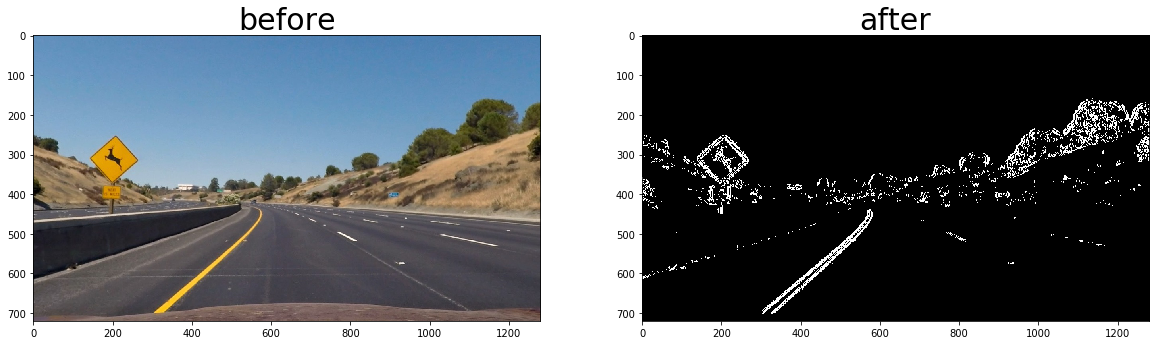

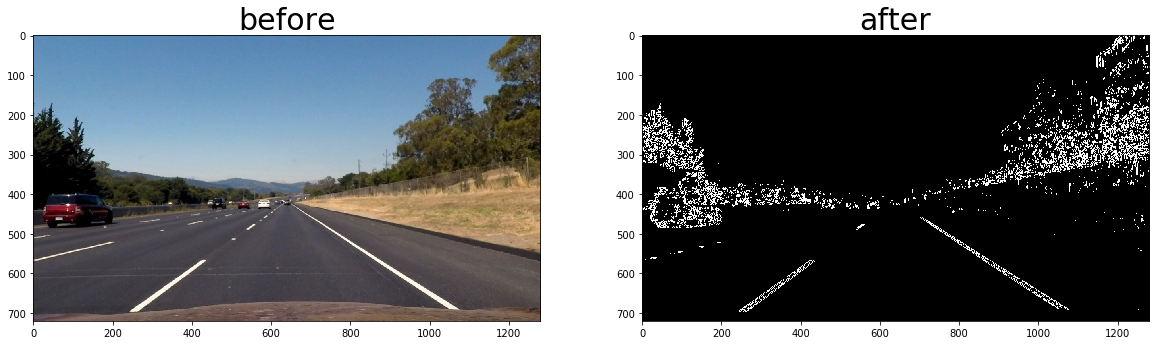

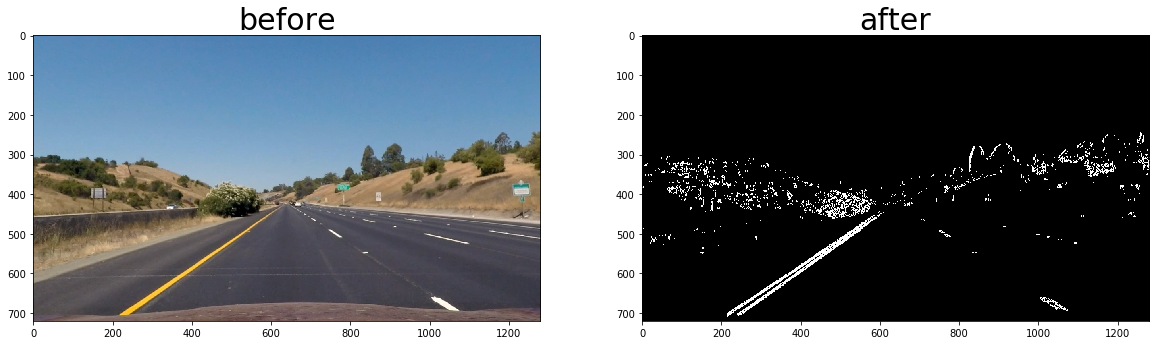

In [8]:
for p in glob.glob('output_images/undist_*.jpg'):
    undist = cv2.imread(p)
    binary = threshold.s_channel_l_channel_sobelx_threshold(undist)
    helper.show_images(undist, binary) #display some samples


# 4. Apply a perspective transform to rectify binary image ("birds-eye view").

The results of some of the perspective transforms don't look very encouraging as of now. But after many tries this seems to be the norm. Because the lane lines on one side are dotted & almost non-existent many binary images just show one line. Frame with shadows is also bringing noise although I thought use of L (light) channel will help me reduce the effect of shadows. Now the hope is that the line fit algorithms with reuse of earlier fits will help fill the gaps in lane detection and smooth things out.

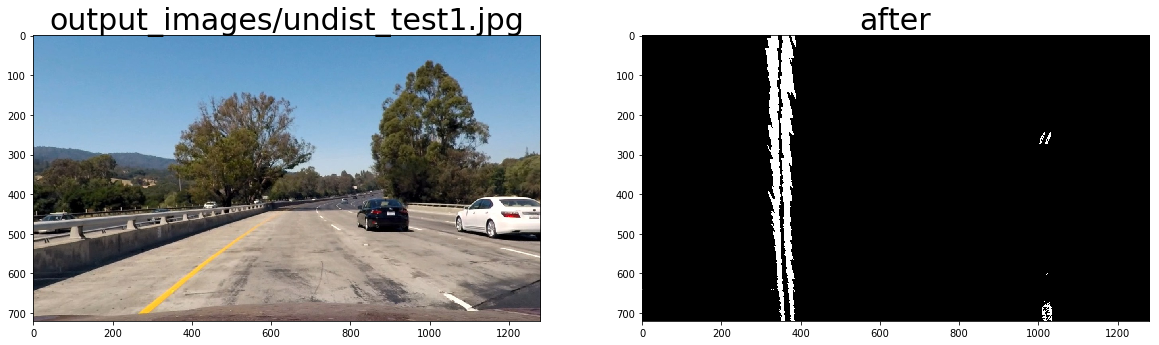

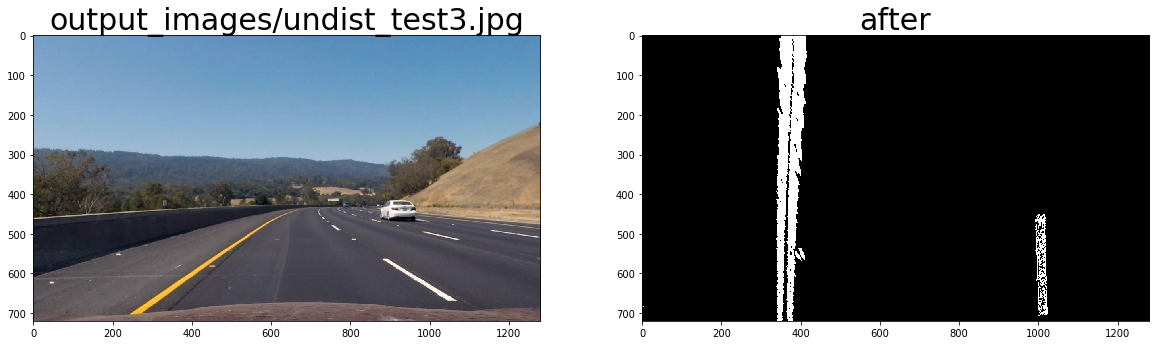

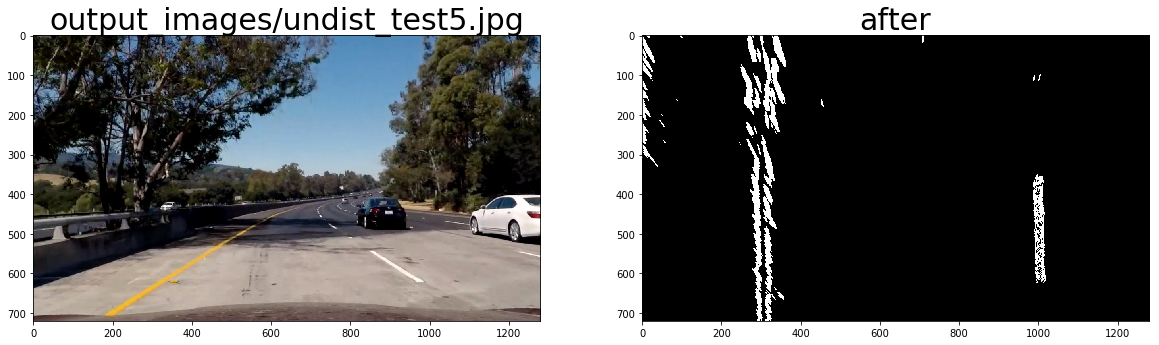

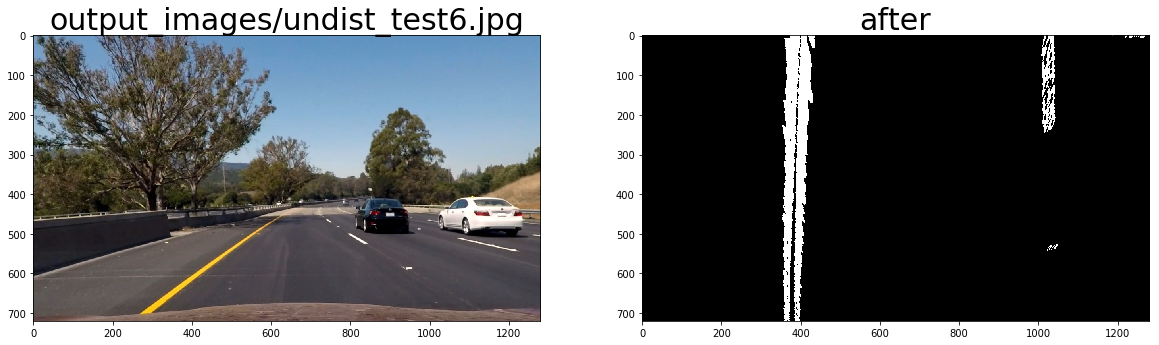

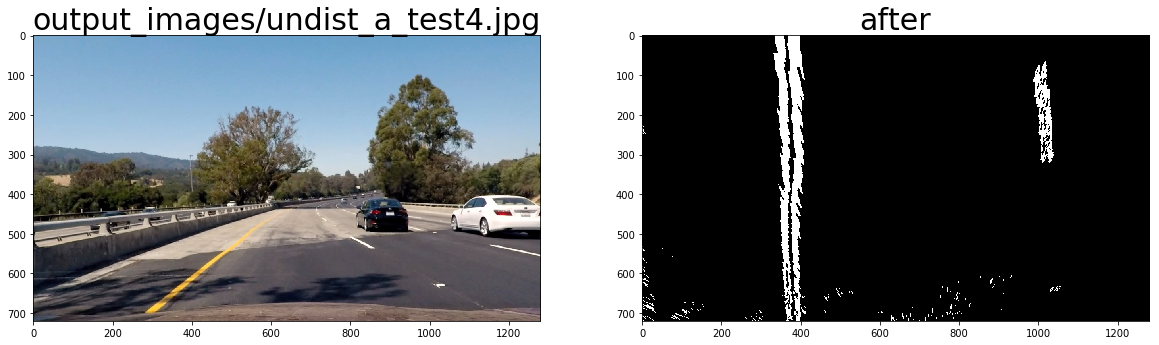

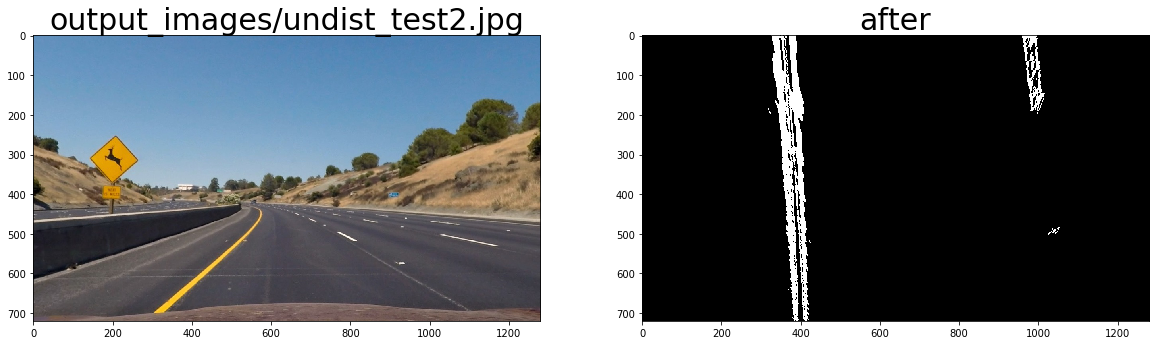

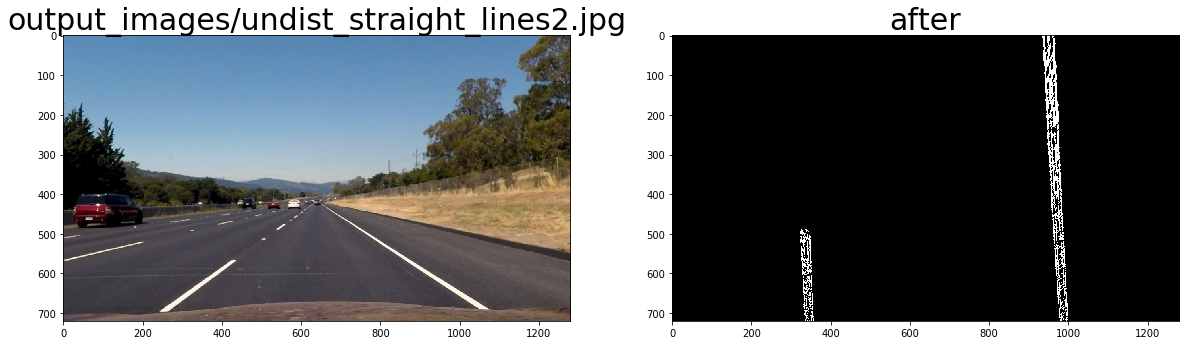

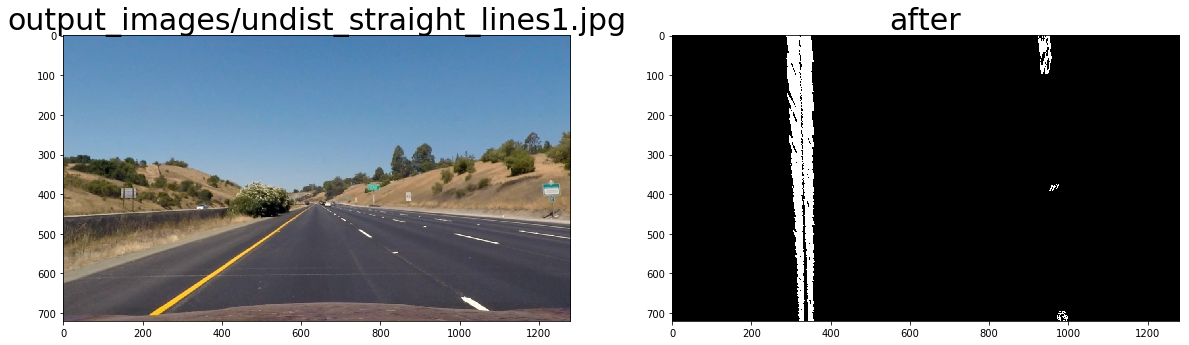

In [9]:
for p in glob.glob('output_images/undist_*.jpg'):
    undist = cv2.imread(p)
    warped, _, _ = camera.perspective_transform(threshold.s_channel_l_channel_sobelx_threshold(undist))
    helper.show_images(undist, warped, p) #display some samples

# 5. Detect lane pixels and fit to find the lane boundary.

### Attempt 1 at fitting Lane using centroids (BAD DETECTION)
Finding fit with windows centroids did not turn out great. The lane with non-continous line almost gets swayed towards the other lane. The results can be seen below.

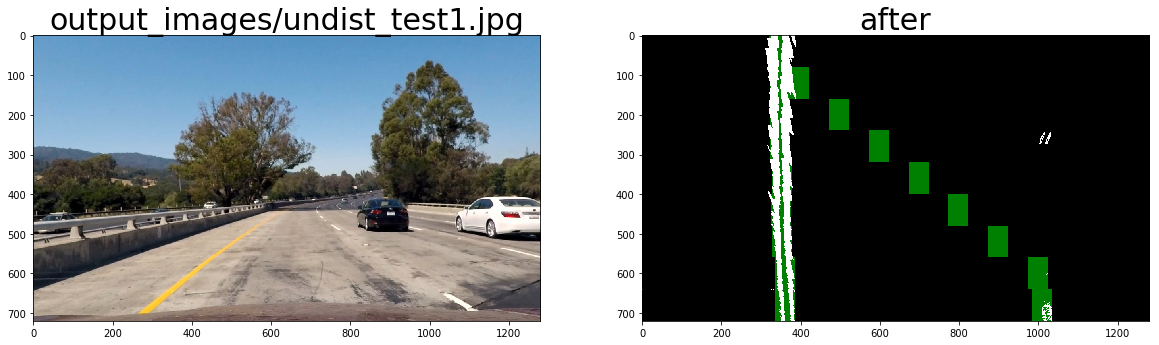

In [10]:
from utils import fit_lane_window_centroids as centroid

def run_window_centroids_fit_lane():
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    for p in glob.glob('output_images/undist_*.jpg')[:2]: #just process 2 frames
        undist = cv2.imread(p)
        warped,_,_ = camera.perspective_transform(threshold.s_channel_l_channel_sobelx_threshold(undist))
        lane = centroid.detect_lane_pixel(warped, window_width, window_height, margin)
        helper.show_images(undist, lane, p) #display some samples
        break #bad result, just exit
        
run_window_centroids_fit_lane()

### Attempt 2 using sliding windows & fit reuse
After unsuccessful attempt with windows centroids, let's try sliding window with fit reuse.
Find Lane points using histogram, separate non-zero points from binary image, for every window pick the points which are inside window and get mean position of points to form the next window. Repeat step to get left/right fits and fit a 2nd order polynomial curve on lanes.
Reuse left/right fits for next frames from the above excercise done on first frame.

In [34]:
def find_lane_pixels(binary_warped, nwindows, margin, minpix):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        print('left_xy ',(win_xleft_low,win_y_low), (win_xleft_high,win_y_high))
        print('right_xy ',(win_xright_low,win_y_low),(win_xright_high,win_y_high))
        print('####')
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        #how to also include coord from nonzeroy together for better decision
        # good_left_inds = [p for p in nonzerox if p >= win_xleft_low and p < win_xleft_high]
        # good_right_inds = [p for p in nonzerox if p >= win_xright_low and p < win_xright_high]
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # if len(good_left_inds) > minpix:
        #     leftx_current = sum(good_left_inds)//len(good_left_inds)
        # if len(good_right_inds) > minpix:
        #     rightx_current = sum(good_right_inds)//len(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

start
size  (720, 1280)
left_xy  (271, 640) (471, 720)
right_xy  (926, 640) (1126, 720)
####
left_xy  (264, 560) (464, 640)
right_xy  (920, 560) (1120, 640)
####
left_xy  (259, 480) (459, 560)
right_xy  (920, 480) (1120, 560)
####
left_xy  (255, 400) (455, 480)
right_xy  (920, 400) (1120, 480)
####
left_xy  (250, 320) (450, 400)
right_xy  (920, 320) (1120, 400)
####
left_xy  (251, 240) (451, 320)
right_xy  (920, 240) (1120, 320)
####
left_xy  (248, 160) (448, 240)
right_xy  (916, 160) (1116, 240)
####
left_xy  (248, 80) (448, 160)
right_xy  (916, 80) (1116, 160)
####
left_xy  (250, 0) (450, 80)
right_xy  (916, 0) (1116, 80)
####
end


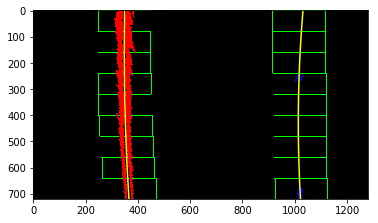

In [35]:
from utils import fit_lane

def first_iteration(warped, nwindows, margin, minpix):
    print('size ', warped.shape)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped, nwindows, margin, minpix)
    left_fitx, right_fitx, ploty = fit_lane.fit_poly(warped.shape, leftx, lefty, rightx, righty)
    result = fit_lane.draw_region_lines(out_img, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty)
    return left_fitx, right_fitx, result

def second_iteration(warped, left_fit, right_fit, margin):
    leftx, lefty, rightx, righty = fit_lane.find_lane_pixels_with_prev_fit(warped, left_fit, right_fit, margin)
    left_fitx, right_fitx, ploty = fit_lane.fit_poly(warped.shape, leftx, lefty, rightx, righty)
    result = fit_lane.draw_green_region_around_lines(warped, left_fitx, right_fitx, ploty, margin)
    result = fit_lane.draw_region_lines(result, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty)
    return left_fitx, right_fitx, result

def fit_window_lane():
    # HYPERPARAMETERS
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    # Choose the number of sliding windows 720 (frame height)/80 (window height) = 9
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    getfits = True
    left_fitx = None
    right_fitx = None
    result = None
    for p in glob.glob('output_images/undist_*.jpg'):
        undist = cv2.imread(p)
        warped, M, Minv = camera.perspective_transform(threshold.s_channel_l_channel_sobelx_threshold(undist))
        if getfits:
            left_fitx, right_fitx, result = first_iteration(warped, nwindows, margin, minpix)
            getfits = False
        else:
            try:
                #continue with initial left_fitx, right_fitx
    #             _, _, result = second_iteration(warped, left_fitx, right_fitx, margin) 
                left_fitx, right_fitx, result = second_iteration(warped, left_fitx, right_fitx, margin) 
            except ValueError:
                print('value error {}'.format(p))
                continue
        
        plt.imshow(result)
        break

#         show_images(undist, result) #display some samples

print('start')
fit_window_lane()
print('end')